## Quick tutorial

`chaospy` is created to work well inside numerical [Python](https://python.org) ecosystem through `numpy`.
It is therefore often necessary to import and use `numpy` along side `chaospy` when working on problems the latter is meant to solve:

In [1]:
import numpy
import chaospy

`chaospy` is very much problem agnostic, so you can use your own code using any means you find fit.
Typically, for the sake of the guide, we assume that whatever you are modelling, it can be placed inside a python function.
It will assume that the funtion input is a vector parameters and the output is the quantity of interest, where both should be compatible with `numpy.ndarray` format.
For this example, let us assume that our model of interest is a simple exponential model that takes 2 parameters in and 100 coordinates out:

In [2]:
coordinates = numpy.linspace(0, 3, 100)

def forward_solver(parameters, coordinates=coordinates):
    """Function to do uncertainty quantification on."""
    param_init, param_rate = parameters
    return param_init*numpy.e**(-param_rate*coordinates)

We assume that the parameters are unknown, the model shape will not have a fixe shape.
For example:

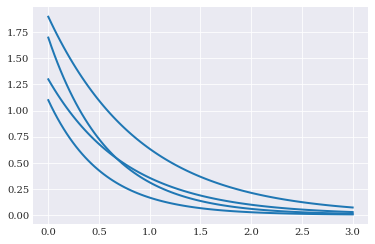

In [3]:
from matplotlib import pyplot

for params in [(1.3, 1.3), (1.7, 1.7), (1.1, 1.9), (1.9, 1.1)]:
    pyplot.plot(coordinates, forward_solver(params))
pyplot.show()

We here assume that `parameters` contains aleatory variability with known probability.
We formalize this probability in `chaospy` as a joint probability distribution.
For example:

In [4]:
distribution = chaospy.J(chaospy.Uniform(1, 2), chaospy.Normal(1.5, 0.3))
distribution

J(Uniform(lower=1, upper=2), Normal(mu=1.5, sigma=0.3))

which we can visualize as follows:

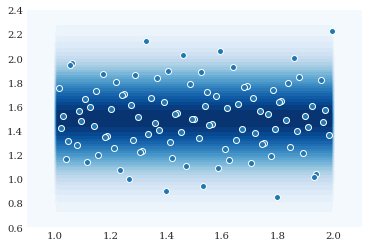

In [5]:
grid = numpy.mgrid[0.9:2.1:100j, 0.6:2.4:100j]
pyplot.contourf(grid[0], grid[1], distribution.pdf(grid), 30)
pyplot.scatter(*distribution.sample(100, rule="sobol"))
pyplot.show()

Most probability distributions have an associated expansion of orthogonal polynomials.
These can be automatically constructed:

In [6]:
expansion = chaospy.generate_expansion(8, distribution)
expansion[:5].round(8)

polynomial([1.0, q1-1.5, q0-1.5, q0*q1-1.5*q1-1.5*q0+2.25,
            q0**2-3.0*q0+2.16666667])

Here the polynomial is defined positional, such that `q0` and `q1` refers to the uniform and normal distribution respectively.

The distribution can also be used to create (pseudo-)random samples and low-discrepancy sequences.
For example to create samples from the Sobol sequence:

In [7]:
samples = distribution.sample(1000, rule="sobol")
samples[:, :4].round(8)

array([[1.5       , 1.75      , 1.25      , 1.375     ],
       [1.5       , 1.29765307, 1.70234693, 1.40440819]])

We can evaluating the forward solver using these samples:

In [8]:
evaluations = numpy.array([forward_solver(sample) for sample in samples.T])
evaluations[:3, :5].round(8)

array([[1.5       , 1.43334455, 1.36965107, 1.30878794, 1.25062938],
       [1.75      , 1.6825205 , 1.61764299, 1.55526714, 1.49529649],
       [1.25      , 1.18715214, 1.12746417, 1.0707772 , 1.01694036]])

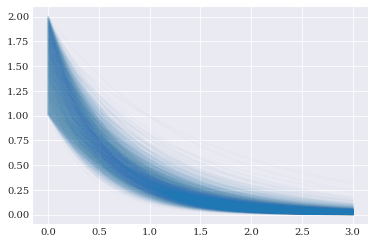

In [9]:
pyplot.plot(coordinates, evaluations.T, alpha=0.02)
pyplot.show()

Having all these components in place, we have enough components to perform point collocation.
Or in other words, we can create a polynomial approximation of ``forward_solver``:

In [10]:
approx_solver = chaospy.fit_regression(expansion, samples, evaluations)
approx_solver[:2].round(4)

polynomial([q0, 0.0005*q0*q1**2-0.0303*q0*q1+q0])

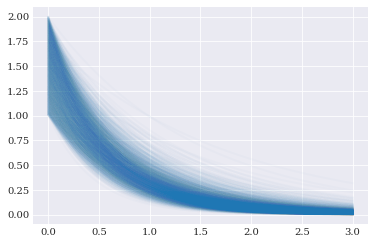

In [11]:
pyplot.plot(coordinates, approx_solver(*samples), alpha=0.02)
pyplot.show()

Since the model approximations are polynomials, we can do inference on them directly.
For example:

In [12]:
expected = chaospy.E(approx_solver, distribution)
expected[:5].round(8)

array([1.5       , 1.43340378, 1.36987748, 1.30927477, 1.25145651])

In [13]:
deviation = chaospy.Std(approx_solver, distribution)
deviation[:5].round(8)

array([0.28867513, 0.27617769, 0.26485055, 0.25458131, 0.24526387])

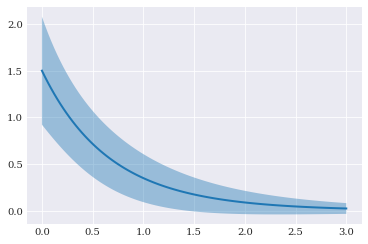

In [14]:
pyplot.fill_between(
    coordinates, expected-2*deviation, expected+2*deviation, alpha=0.4)
pyplot.plot(coordinates, expected)
pyplot.show()

And that is the gist of how you can use `chaospy`.